In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import datasets, transforms, models
import os 
from PIL import Image

In [2]:
data_dir = 'Classify'

# Define transforms for the Training data and Testing data
Train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

Test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
Train_data = datasets.ImageFolder(data_dir + '/Train', transform=Train_transforms)
Test_data = datasets.ImageFolder(data_dir + '/Test', transform=Test_transforms)

Trainloader = torch.utils.data.DataLoader(Train_data, batch_size=8, shuffle=True)
Testloader = torch.utils.data.DataLoader(Test_data, batch_size=8)

In [3]:
num_classes = len(Train_data.class_to_idx)
num_classes

3

In [4]:
Train_data.class_to_idx

{'Bus': 0, 'Car': 1, 'Cycle': 2}

In [5]:
model = models.resnet18(pretrained=True)
model.fc

C:\Users\lopam\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\lopam\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=1000, bias=True)

In [6]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = fc

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
model.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 400)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(400, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
for epoch in range(epochs):
    for inputs, labels in Trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            Test_loss = 0
            accuracy = 0
            model.eval()
            
            confusion_matrix = torch.zeros(num_classes, num_classes)
            with torch.no_grad():
                for inputs, labels in Testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    Test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    for t, p in zip(labels.view(-1), top_class.view(-1)):
                            confusion_matrix[t.long(), p.long()] += 1
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {Test_loss/len(Testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(Testloader):.3f}")
            print(confusion_matrix)
            running_loss = 0
            model.train()

C:\Users\lopam\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10.. Train loss: 1.324.. Test loss: 0.545.. Test accuracy: 0.703
tensor([[20.,  0.,  0.],
        [18.,  2.,  0.],
        [ 1.,  0., 19.]])
Epoch 1/10.. Train loss: 1.052.. Test loss: 0.451.. Test accuracy: 0.891
tensor([[17.,  3.,  0.],
        [ 0., 20.,  0.],
        [ 1.,  2., 17.]])
Epoch 1/10.. Train loss: 0.771.. Test loss: 0.352.. Test accuracy: 0.906
tensor([[20.,  0.,  0.],
        [ 4., 15.,  1.],
        [ 1.,  0., 19.]])
Epoch 2/10.. Train loss: 0.547.. Test loss: 0.289.. Test accuracy: 0.938
tensor([[19.,  1.,  0.],
        [ 1., 18.,  1.],
        [ 1.,  0., 19.]])
Epoch 2/10.. Train loss: 0.527.. Test loss: 0.280.. Test accuracy: 0.922
tensor([[18.,  2.,  0.],
        [ 0., 20.,  0.],
        [ 1.,  1., 18.]])
Epoch 2/10.. Train loss: 0.516.. Test loss: 0.196.. Test accuracy: 0.969
tensor([[20.,  0.,  0.],
        [ 1., 19.,  0.],
        [ 1.,  0., 19.]])
Epoch 3/10.. Train loss: 0.458.. Test loss: 0.173.. Test accuracy: 0.938
tensor([[19.,  1.,  0.],
        

In [11]:
# Save the trained model weights
torch.save(model.state_dict(), 'model.pth')

In [12]:
# Load saved model
def load_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(512, 400)),
                      ('relu', nn.ReLU()),
                      ('fc2', nn.Linear(400, 3)),
                      ('output', nn.LogSoftmax(dim=1))
                      ]))

    model.load_state_dict(ckpt, strict=False)

    return model

In [13]:
SAVE_PATH = 'model.pth'

In [14]:
# load model
model = load_ckpt(SAVE_PATH)

In [15]:
import PIL
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an torch Tensor
    '''
    im = PIL.Image.open(image)
    return test_transforms(im)

In [16]:
def predict(image_path, model):
    # Predict the class of an image using a trained deep learning model.
    model.eval()
    img_pros = process_image(image_path)
    img_pros = img_pros.view(1,3,224,224)
    with torch.no_grad():
        output = model(img_pros)
    return output

In [17]:
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

Car


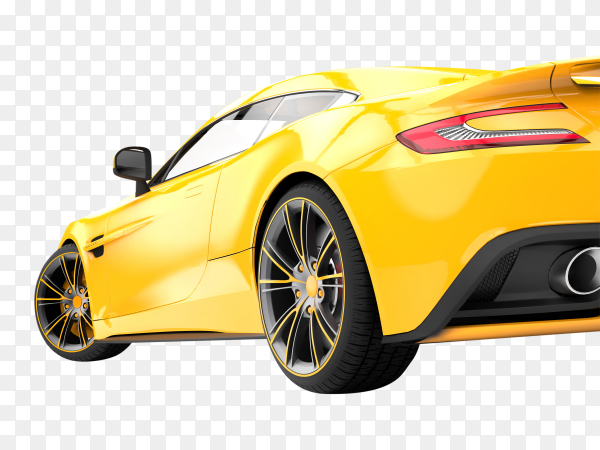

In [18]:
img_path = '1.png'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Bus


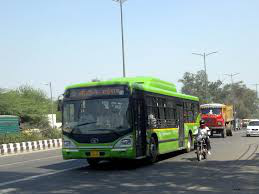

In [19]:
img_path = '2.jpg'
#test_image = Image.open(img_path).convert('RGB')
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Cycle


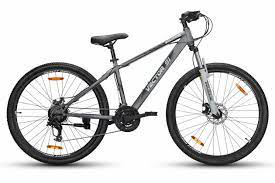

In [20]:
img_path = '3.jpg'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Car


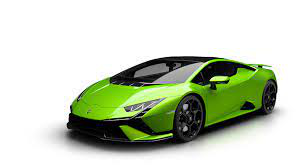

In [21]:
img_path = '4.jpg'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Cycle


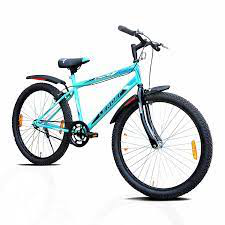

In [22]:
img_path = '5.jpg'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Car


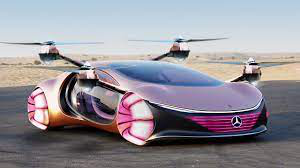

In [23]:
img_path = '6.jpg'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Bus


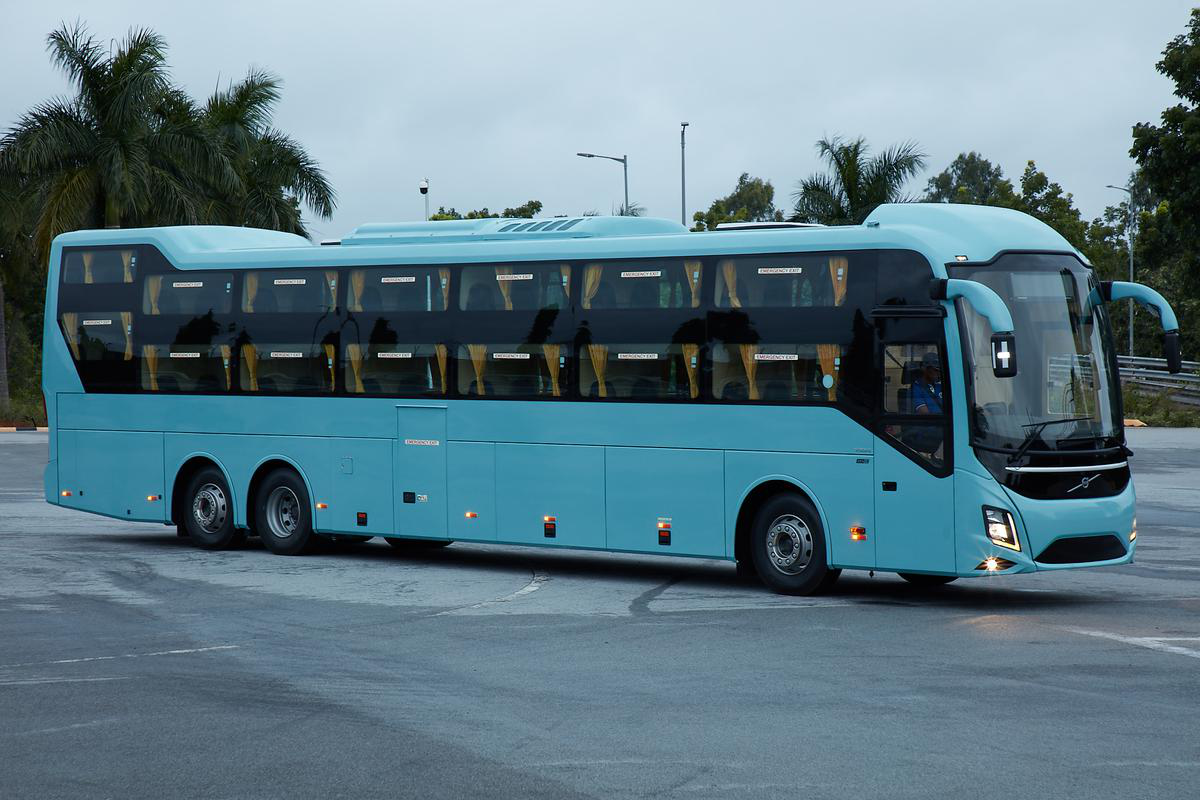

In [24]:
img_path = '7.jpg'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Car


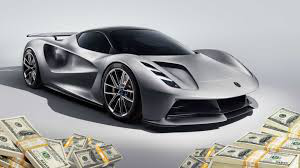

In [25]:
img_path = '8.jpg'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Cycle


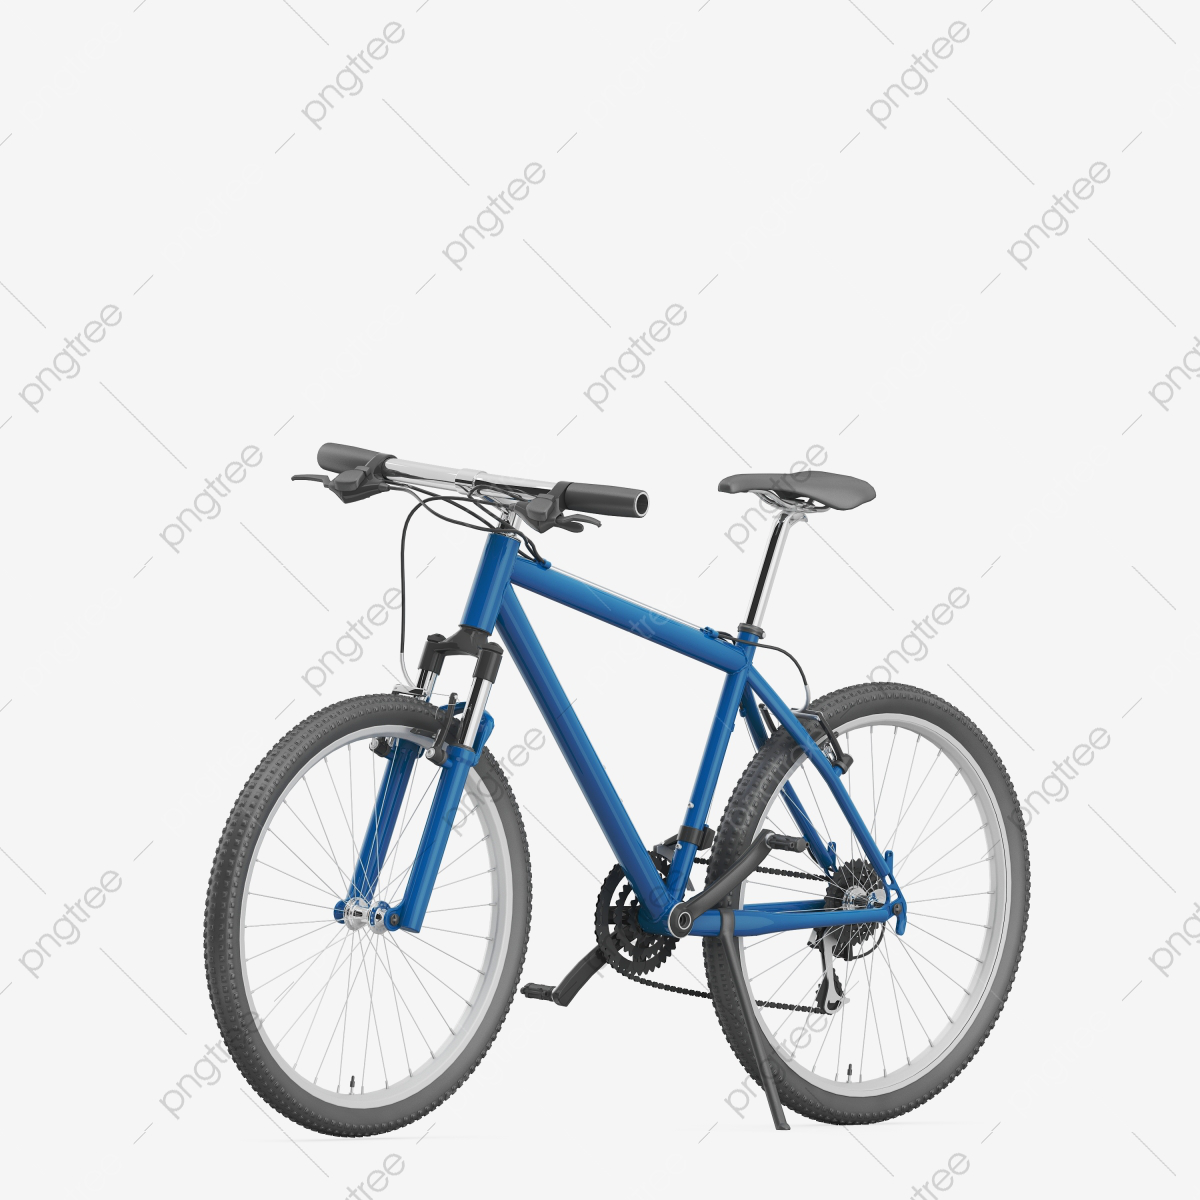

In [26]:
img_path = '9.jpg'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)

Car


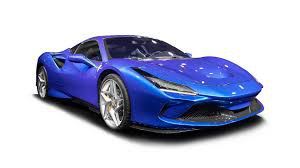

In [27]:
img_path = '10.jpg'
log_ps = predict(img_path, model)
cls_score = int(torch.argmax(torch.exp(log_ps)))
if cls_score == 0:
    print('Bus')
elif cls_score==1:
    print('Car')
else:
    print('Cycle')
PIL.Image.open(img_path)